# Bird Observations in Oklahoma and Arkansas from January 2022 through November 2023
---
Project conducted by ***Ian Brandenburg***

This project takes a look at bird observations from Oklahoma and Arkansas in the United States. These states are situated next to each other, but have very different observation patterns for certain species of bird. These could be connected to weather patterns and migration streams. 

The data was collected from the Cornell University's Ornithology Lab. The Cornell Lab of Ornithology launched a digital project named eBird for the purpose of acquiring bird observation data from birdwatchers around the world, and the project was a huge success. Large quantities of data are collected and submitted to this platform everyday. For more information about eBird, follow this link! **[About eBird](https://ebird.org/about)**. 

eBird has large data storages, and allow researchers access to this treasure-trove of bird data. I submitted a request to this database for academic purposes, and was granted access for projects like this. Once grated access, the data can be found at the following link: **[eBird Data](https://ebird.org/data/download/ebd)** As the datasets are extremely large, they are submitted to the research as a text file. From here, I transformed the .txt file into a .csv file. The .csv file was too large to upload to github, so it was then zipped for easier storage. An unzipping function is included in the beginning of this code to unzip the .csv file from the Github link, and read the .csv into a dataframe.

This project identifies and creates visuals for the following subjects:
- Top 10 observed species by state
- Monthly time series observations of the most observed species by state
- Monthly time series state comparative observations for a selected species

A link to the GitHub repository is provided here: [Bird Observations in Oklahoma and Arkansas from January 2022 through November 2023](https://github.com/Iandrewburg/DV2_Assignment/tree/main) 

Additionally, the zipped csv files are found with the following links, but also are already included in the code: 
- [Oklahoma Observations 2021-2022](https://github.com/Iandrewburg/DV2_Assignment/blob/main/OK_Data.zip?raw=true)
- [Arkansas Observations 2021-2022](https://github.com/Iandrewburg/DV2_Assignment/blob/main/AK_Data.zip?raw=true)

---


### Import Libraries
---

In [1]:
from dash import Dash
from dash import html, dcc 
from dash import callback, Output, Input
import plotly.express as px
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import zipfile
import io
import dash


---
### Function that reads the zipped csv into a variable
---

In [2]:
def read_csv_from_zip_url(url):
    """
    This function obtains a zipped csv from a URL. 
    It is assumed that there is only one csv in the zipped folder. 
    Additionally, this function reads the csv into a variable instead of loading a csv into your operating system. 
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
        # Assuming there's only one file in the zip
        csv_file_name = zipf.namelist()[0]
        with zipf.open(csv_file_name) as csv_file:
            return pd.read_csv(csv_file)


In [3]:
# executing the function and reading the zip into the variables
OK_Data = read_csv_from_zip_url('https://github.com/Iandrewburg/DV2_Assignment/blob/main/OK_Data.zip?raw=true')
AK_Data = read_csv_from_zip_url('https://github.com/Iandrewburg/DV2_Assignment/blob/main/AK_Data.zip?raw=true')


C:\Users\iandr\AppData\Local\Temp\ipykernel_15812\3498678409.py:12: DtypeWarning: Columns (14,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_file)
C:\Users\iandr\AppData\Local\Temp\ipykernel_15812\3498678409.py:12: DtypeWarning: Columns (21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_file)


---
### Data processing function
----

In [4]:
def ebird_data_processor(data):
    """
    Example usage: 
    ebird_data_processor(OK_Data)
    
    This function cleans ebird data. The following list shows what this function executes within the dataframe: 
    - Converts the observation counts to numeric data, and explaces 'X' with '0'
    - Replaces spaces with '_'
    - Creates a Year column for yearly analyses
    - Creates a month column that names the months by their English names
    - Creates a year_month column for yearly analyses broken up by month
    - Drops unnecessary columns
    """

    data['OBSERVATION COUNT'] = pd.to_numeric(data['OBSERVATION COUNT'].str.replace('X', '0').str.strip())
    data.columns = data.columns.str.replace(' ', '_')
    data['OBSERVATION_DATE'] = pd.to_datetime(data['OBSERVATION_DATE'])
    data['YEAR'] = data['OBSERVATION_DATE'].dt.year
    data['MONTH'] = data['OBSERVATION_DATE'].dt.strftime('%B')
    data['year_month'] = data['OBSERVATION_DATE'].dt.strftime('%Y-%m')

    # Columns to drop
    columns_to_drop = ['LAST_EDITED_DATE', 'TAXONOMIC_ORDER', 'CATEGORY', 'TAXON_CONCEPT_ID',
                       'SUBSPECIES_COMMON_NAME', 'SUBSPECIES_SCIENTIFIC_NAME', 'EXOTIC_CODE',
                       'BREEDING_CODE', 'BREEDING_CATEGORY', 'BEHAVIOR_CODE', 'AGE/SEX', 'COUNTRY', 
                       'COUNTRY_CODE', 'STATE_CODE', 'COUNTY_CODE', 'IBA_CODE', 'BCR_CODE',
                       'ATLAS_BLOCK', 'LOCALITY', 'LOCALITY_ID', 'USFWS_CODE', 'LOCALITY_TYPE',
                       'SAMPLING_EVENT_IDENTIFIER', 'PROTOCOL_TYPE', 'PROTOCOL_CODE', 'PROJECT_CODE',
                       'EFFORT_AREA_HA', 'ALL_SPECIES_REPORTED', 'GROUP_IDENTIFIER', 'HAS_MEDIA', 
                       'APPROVED', 'REVIEWED', 'REASON', 'TRIP_COMMENTS', 'SPECIES_COMMENTS', 
                       'Unnamed:_49']

    data = data.drop(columns=columns_to_drop, errors='ignore')

    return data


In [5]:
# executing the ebird_data_processor on the dataframes
OK_Data = ebird_data_processor(OK_Data)
AK_Data = ebird_data_processor(AK_Data)


---
### Concat the dataframes
---

In [6]:
# concat the Arkansas and Oklahoma dataframes
AK_OK_Data= pd.concat([AK_Data, OK_Data], ignore_index=True)


---
### Set formatting variables
---

In [7]:
labels_ = {'COMMON_NAME': 'Common Name', 'OBSERVATION_COUNT': 'Observation Count', 'year_month': 'Year-Month', 'STATE': 'State'}
chart_size = {'height' : 550, 'width' : 1200}


---
### Set function for creating a px.bar for the top 10 species for a specified state
---

In [8]:
def plot_top10_birds_by_state(dataframe, state):
    
    """
    This function creates a filtered and grouped dataframe for a specified state. 
    The state entered into the function will create a new dataframe specifically for that state. 
    The states should be formatted as so: 'Oklahoma' 'Arkansas'.
    
    First, the state dataframe is groupyed by common names and observation count 
    to take the sum of the observations for each species.
    Then, a new dataframe is creates to show the top 10 species within the state by observation count. 
    
    Finally, this function will create a plot for the filtered dataframe top 10 birds. 
    """
    
    # Filter the DataFrame for the specified state
    state_data = dataframe[dataframe['STATE'] == state]
    
    # Group by common name and calculate sum of observation counts
    species_observation_counts = state_data.groupby('COMMON_NAME')['OBSERVATION_COUNT'].sum().reset_index()
    
    # Sort the species by observation count in descending order and get the top 10
    top10_species = species_observation_counts.sort_values('OBSERVATION_COUNT', ascending=False).head(10)
    
    # Plot the bar chart
    fig = px.bar(top10_species, x='COMMON_NAME', y='OBSERVATION_COUNT',
                 title=f'Top 10 Observed Species in {state} by Observation Count',
                 text_auto=True)
    fig.update_layout(title_x=0.5, plot_bgcolor='white')
    fig.update_layout(chart_size, xaxis_title=None, template='simple_white')
    fig.update_yaxes(visible=False)
    fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')
    
    return fig


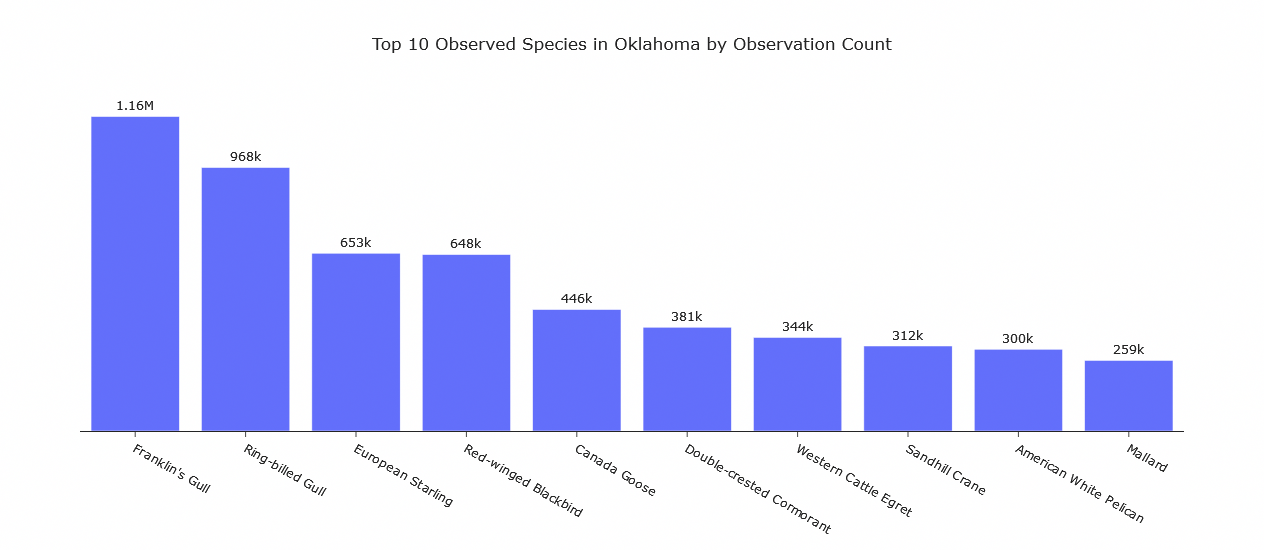

In [9]:
# usage of plot_top10_birds_by_state for example
fig = plot_top10_birds_by_state(AK_OK_Data, 'Oklahoma')
fig.show()


---
### Set function for displaying the observation counts for the top observed bird by state over a time series
---

In [10]:
def plot_top_bird_by_state(dataframe, state):

    """
    Enter desired dataframe and state: 
    example: plot_top_bird_by_state(AK_OK_Data, 'Arkansas')
    
    This function creates a filtered and grouped dataframe for a specified state. 
    The state entered into the function will create a new dataframe specifically for that state. 
    The states should be formatted as so: 'Oklahoma' 'Arkansas'. 
    
    This function will take the state filtered dataset, and single out the most observed bird for that state.
    
    The data is further aggregated by observation per month, for easier plotting. 
    Several measures are taken to ensure the 'year_month' column is the appropriate dtype for plotting ->
    ...this is due to the coder's anxiety of the kernel crashing...again.  
    
    The plot generated by this function displays observations of the top species over the dataset time-frame. 
    """
    # Filter the DataFrame for the specified state
    state_data = dataframe[dataframe['STATE'] == state]

    # Ensure 'year_month' is in the correct datetime format for grouping
    state_data['year_month'] = pd.to_datetime(state_data['year_month'])

    # Identify the top observed bird species in the state
    top_bird = state_data.groupby('COMMON_NAME')['OBSERVATION_COUNT'].sum().idxmax()

    # Filter the DataFrame for only the top bird species in the state
    top_bird_data = state_data[state_data['COMMON_NAME'] == top_bird]

    # Aggregate the observation count by month
    monthly_aggregated_data = top_bird_data.groupby(top_bird_data['year_month'].dt.to_period('M'))['OBSERVATION_COUNT'].sum().reset_index()

    # Convert the period to datetime to be able to plot
    monthly_aggregated_data['year_month'] = monthly_aggregated_data['year_month'].dt.to_timestamp()

    # Plot the bar chart
    fig = px.bar(monthly_aggregated_data, x='year_month', y='OBSERVATION_COUNT',
                 title=f"Observations of {state}'s Most Observed Species: {top_bird}",
                 text_auto = True)
    fig.update_layout(title_x=0.5, plot_bgcolor = 'white')
    fig.update_layout(chart_size, xaxis_title = None, template = 'simple_white')
    fig.update_yaxes(visible = False)
    fig.update_traces(texttemplate = '%{value:.3s}', textposition = 'outside')

    return fig


C:\Users\iandr\AppData\Local\Temp\ipykernel_15812\2950677208.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\iandr\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



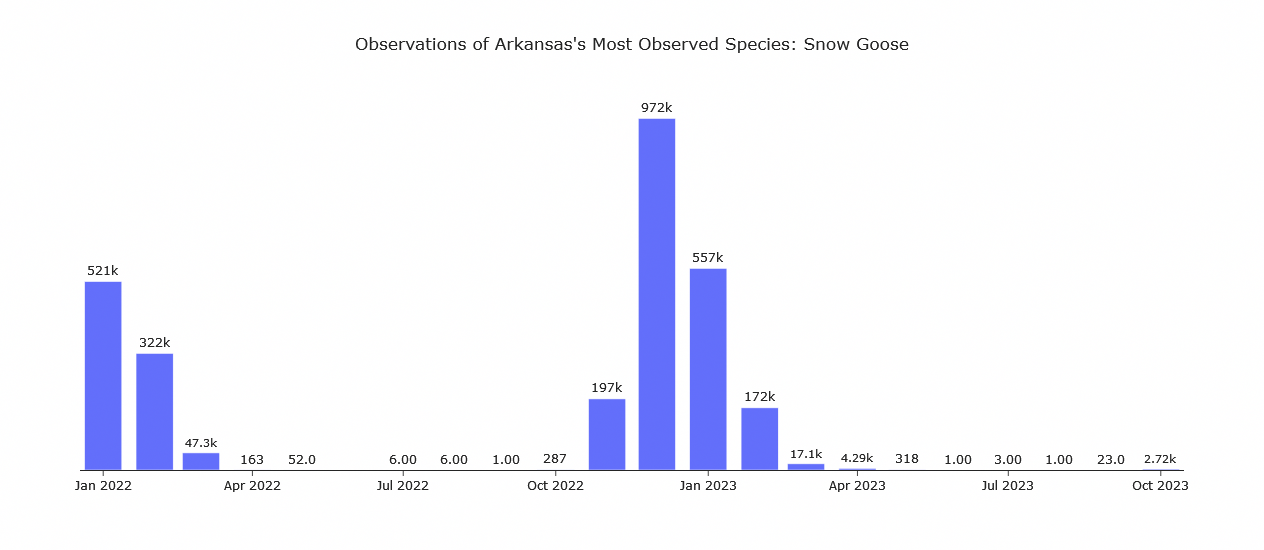

In [11]:
# Example of plot_monthly_aggregated_bar_chart usage
fig = plot_top_bird_by_state(AK_OK_Data, 'Arkansas')
fig.show()


---
### Set function for generating a state comparison chart for a specified bird species over a time series
---

In [12]:
def plot_species_comparison_by_state(dataframe, bird_species):

    """
    The purpose of this function is to create a state comparative visual for the
    observation counts of a specific species over a time series. 
    
    This function starts with creating a new dataframe for the specified species.
    From here, the filtered data frame is grouped by month and observation count. 
    
    The function then executes a bar chart that will show the state comparison
    of observation counts for the specified species over duration of the time frame. 
    """
    
    # Filter the DataFrame for the specified bird species
    species_data = dataframe[dataframe['COMMON_NAME'] == bird_species]

    # Ensure 'year_month' is in the correct datetime format for grouping
    species_data['year_month'] = pd.to_datetime(species_data['year_month'])

    # Aggregate the observation count by month and state
    monthly_state_aggregated_data = species_data.groupby([species_data['year_month'].dt.to_period('M'), 'STATE'])['OBSERVATION_COUNT'].sum().reset_index()

    # Convert the period to datetime to be able to plot
    monthly_state_aggregated_data['year_month'] = monthly_state_aggregated_data['year_month'].dt.to_timestamp()

    # Plot the bar chart
    fig = px.bar(monthly_state_aggregated_data, x='year_month', y='OBSERVATION_COUNT', color='STATE',
                 title=f'Monthly Observation Count Comparison of {bird_species} by State',
                 labels=labels_,
                barmode = 'group')
    fig.update_layout(title_x=0.5, plot_bgcolor = 'white')
    fig.update_layout(chart_size, xaxis_title = None, yaxis_title = None, template = 'simple_white')
    fig.update_yaxes(visible = True)
    

    return fig


C:\Users\iandr\AppData\Local\Temp\ipykernel_15812\3301362842.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\iandr\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



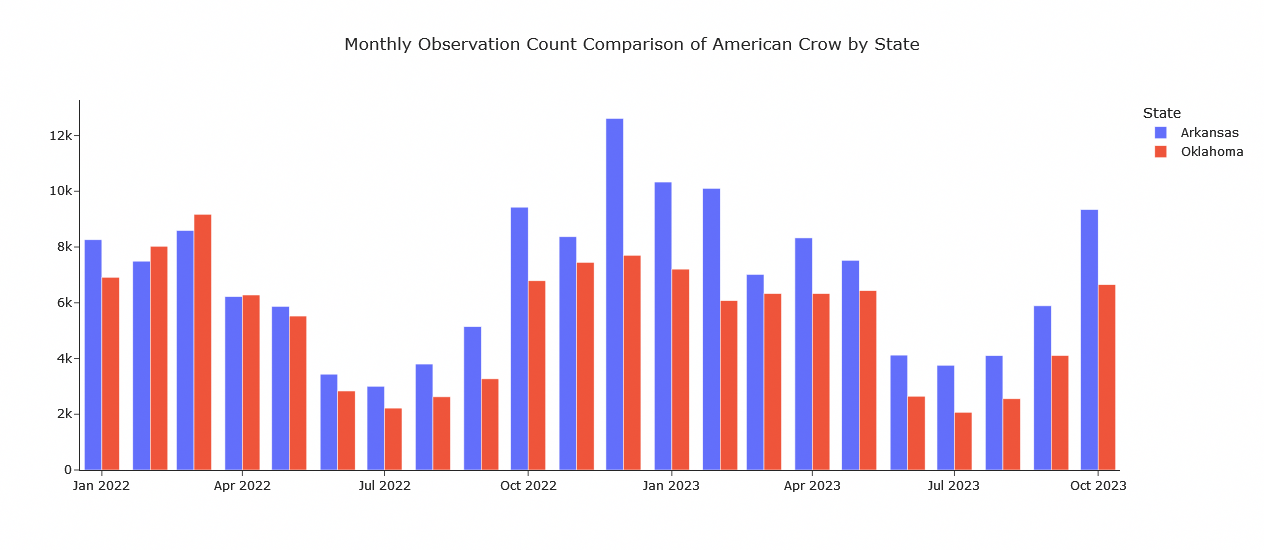

In [13]:
# example of plot_species_comparison_by_state usage
fig = plot_species_comparison_by_state(dataframe=AK_OK_Data, bird_species="American Crow")
fig.show()


---
# Dash App
---

In [14]:
app = dash.Dash(__name__)

bird_data = AK_OK_Data

state_list = [{'label': state, 'value': state} for state in bird_data['STATE'].unique()]
species_list = [{'label': species, 'value': species} for species in bird_data['COMMON_NAME'].unique()]

app.layout = html.Div([
    # title of the dash app
    html.H1(children="Bird Observation Dashboard", style={'textAlign':'center'}),
    
    # set state selection drop down menu
    html.Label('Select the state:', style={'font-weight': 'bold', "text-align": "center"}),
    dcc.Dropdown(id='state-dropdown', options= state_list, value=bird_data['STATE'].unique()[0], clearable=False),
    
    # set species selection drop down menu
    html.Label('Select the species:', style={'font-weight': 'bold', "text-align": "center"}),
    dcc.Dropdown(id='bird-species-dropdown', options= species_list, value=bird_data['COMMON_NAME'].unique()[0], clearable=False),
    
    # set the graphs
    html.Div(dcc.Graph(id='top10-birds-chart'), style = {'display': 'inline-block', 'width': '200%'}),
    html.Div(dcc.Graph(id='top_species_by_state'),  style = {'display': 'inline-block', 'width': '100%'}),
    html.Div(dcc.Graph(id='species-comparison-chart'),  style = {'display': 'inline-block', 'width': '100%'}),
])

# parameters for the top 10 chart by state plot
@app.callback(
    Output('top10-birds-chart', 'figure'),
    Input('state-dropdown', 'value')
)
def update_top10_chart(selected_state):
    fig = plot_top10_birds_by_state(bird_data, selected_state)
    return fig

# parameters for the most observed bird by state time series plot
@app.callback(
    Output('top_species_by_state', 'figure'),
    Input('state-dropdown', 'value')
)
def update_top_bird_by_state(selected_state):
    fig = plot_top_bird_by_state(bird_data, selected_state)
    return fig

# parameters for state comparisons of species by observation counts in a time series plot
@app.callback(
    Output('species-comparison-chart', 'figure'),
    Input('bird-species-dropdown', 'value')
)
def update_species_comparison_chart(selected_species):
    fig = plot_species_comparison_by_state(bird_data, selected_species)
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


C:\Users\iandr\AppData\Local\Temp\ipykernel_15812\3301362842.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\iandr\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\iandr\AppData\Local\Temp\ipykernel_15812\2950677208.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin